In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
import pandas as pd



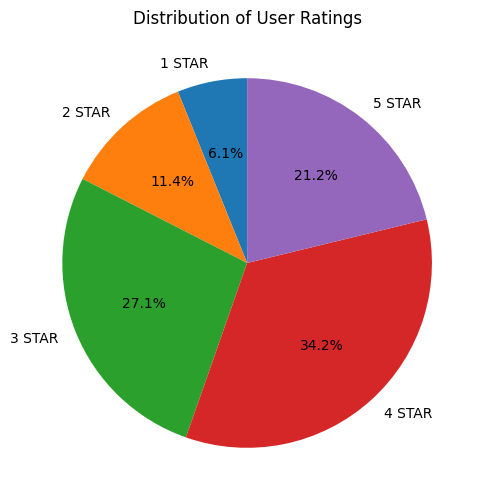

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('udata.txt', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])



rating_counts = df['rating'].value_counts().sort_index()

labels = [f'{int(r)} STAR' for r in rating_counts.index]


plt.figure(figsize=(6,6))
plt.pie(rating_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Distribution of User Ratings')
plt.show()


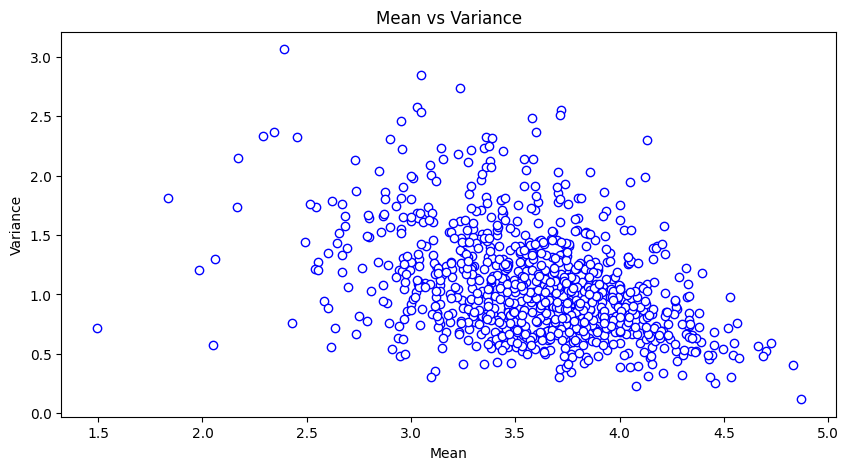

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

user_stats = df.groupby('user_id')['rating'].agg(['mean', 'var']).dropna()

plt.figure(figsize=(10, 5))
plt.scatter(user_stats['mean'], user_stats['var'],color='white', edgecolor='blue')

plt.title('Mean vs Variance')
plt.xlabel('Mean')
plt.ylabel('Variance')

plt.show()


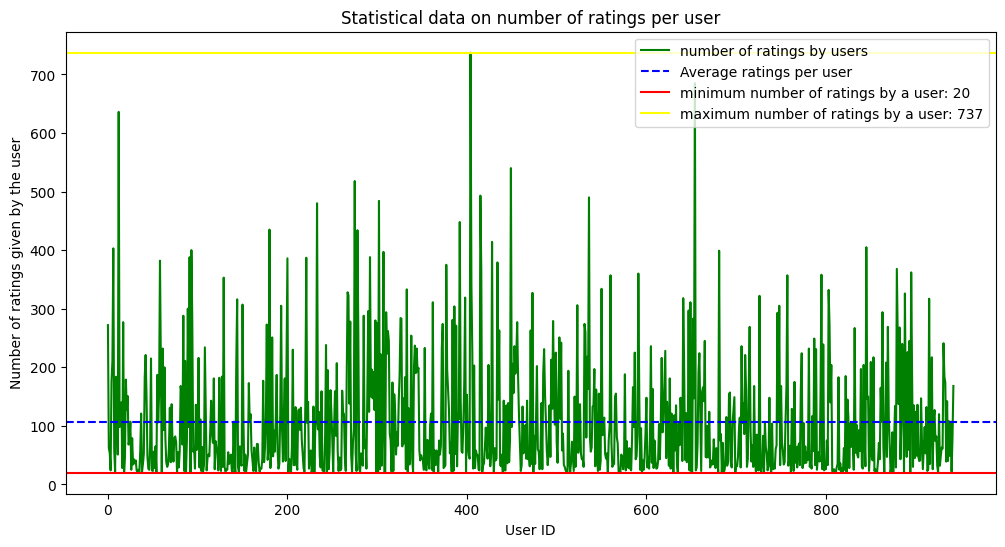

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

user_ratings_count = df.groupby('user_id')['rating'].count()

average_ratings = user_ratings_count.mean()
min_ratings = user_ratings_count.min()
max_ratings = user_ratings_count.max()

plt.figure(figsize=(12, 6))

plt.plot(user_ratings_count.values, color='green', label='number of ratings by users')

plt.axhline(average_ratings, color='blue', label='Average ratings per user', linestyle='--')

plt.axhline(min_ratings, color='red', label=f'minimum number of ratings by a user: {min_ratings}', linestyle='-')

plt.axhline(max_ratings, color='yellow', label=f'maximum number of ratings by a user: {max_ratings}', linestyle='-')

plt.xlabel('User ID')
plt.ylabel('Number of ratings given by the user')
plt.title('Statistical data on number of ratings per user')

plt.legend()

plt.show()


In [ ]:
ratings_df = pd.read_csv('udata.txt', sep='\t',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df = ratings_df.drop('timestamp', axis=1)

In [ ]:
movies_df = pd.read_csv('uitem.txt', sep='|', header=None, encoding='latin-1')
movies_df = movies_df[[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]
movies_df.columns = ['movie_id', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
                     "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western']
movies_df['movie_id'] = movies_df['movie_id'].astype(int)

In [ ]:
# Preprocess data
R_df = ratings_df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = R_df.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [ ]:
def collaborative_filtering_prediction(user_id, movie_id, matrix_svd, matrix_svd_VT):
    try:
        pred = np.dot(matrix_svd[user_id - 1], matrix_svd_VT[:, movie_id - 1])
        return min(5, max(1, pred))
    except:
        return ratings_df['rating'].mean()

In [ ]:
# --- Content-Based Filtering Model ---
def content_based_filtering_prediction(user_id, movie_id, tfidf_matrix, movies_df):
    try:
        user_profile = R_df.loc[user_id].values
        movie_index = movies_df[movies_df['movie_id'] == movie_id].index[0]
        movie_vector = tfidf_matrix[movie_index]
        similarity_scores = cosine_similarity(user_profile.reshape(1, -1), tfidf_matrix)
        weighted_sum = np.dot(similarity_scores, R_df.values)[0]
        sum_of_similarities = np.sum(similarity_scores)
        if sum_of_similarities == 0:
            return ratings_df['rating'].mean()
        prediction = weighted_sum / sum_of_similarities
        return min(5, max(1, prediction))
    except:
        return ratings_df['rating'].mean()

In [ ]:
# --- Hybrid Model ---
def hybrid_prediction(user_id, movie_id, matrix_svd, matrix_svd_VT, tfidf_matrix, movies_df, w1=0.5, w2=0.5):
    cf_pred = collaborative_filtering_prediction(user_id, movie_id, matrix_svd, matrix_svd_VT)
    cb_pred = content_based_filtering_prediction(user_id, movie_id, tfidf_matrix, movies_df)
    return w1 * cf_pred + w2 * cb_pred

In [ ]:
# Collaborative Filtering
n_components = 50
svd = TruncatedSVD(n_components=n_components)
matrix_svd = svd.fit_transform(R_demeaned)
matrix_svd_VT = svd.components_

In [ ]:
# Content-Based Filtering
genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df['genres'] = movies_df[genre_columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)

custom_stop_words = []
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf.fit_transform(movies_df[genre_columns])

In [ ]:
models = {
    'Collaborative Filtering': collaborative_filtering_prediction,
    'Content-Based Filtering': content_based_filtering_prediction,
    'Hybrid': hybrid_prediction
}

rmse_results = {}

for model_name, prediction_func in models.items():
    predictions = []
    for _, row in ratings_df.iterrows():
        if model_name == 'Collaborative Filtering':
            pred = prediction_func(row['user_id'], row['movie_id'], matrix_svd, matrix_svd_VT)
        elif model_name == 'Content-Based Filtering':
            pred = prediction_func(row['user_id'], row['movie_id'], tfidf_matrix, movies_df)
        else:
            pred = prediction_func(row['user_id'], row['movie_id'], matrix_svd, matrix_svd_VT, tfidf_matrix, movies_df)
        predictions.append(pred)
    actuals = ratings_df['rating'].values
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_results[model_name] = rmse
    print(f"{model_name} RMSE: {rmse:.4f}")



Collaborative Filtering RMSE: 1.9484
Content-Based Filtering RMSE: 1.1257
Hybrid RMSE: 1.2719


In [ ]:

predicted_ratings = {}

for model_name, prediction_func in models.items():
    predicted_ratings[model_name] = {}
    for _, row in ratings_df.iterrows():
        if model_name == 'Collaborative Filtering':
            pred = prediction_func(row['user_id'], row['movie_id'], matrix_svd, matrix_svd_VT)
        elif model_name == 'Content-Based Filtering':
            pred = prediction_func(row['user_id'], row['movie_id'], tfidf_matrix, movies_df)
        else:
            pred = prediction_func(row['user_id'], row['movie_id'], matrix_svd, matrix_svd_VT, tfidf_matrix, movies_df)
        predicted_ratings[model_name][row['user_id'], row['movie_id']] = pred

In [ ]:
import pandas as pd

top_n = 5
desired_users = [1, 2, 3,4,5]
recommendations = {}

for model_name, ratings in predicted_ratings.items():
    recommendations[model_name] = {}


    user_ratings = {}
    for (user_id, movie_id), rating in ratings.items():
        if user_id not in user_ratings:
            user_ratings[user_id] = []
        user_ratings[user_id].append((movie_id, rating))

    for user_id in desired_users:
        if user_id in user_ratings:

            movie_ratings = user_ratings[user_id]
            sorted_movies = sorted(movie_ratings, key=lambda x: x[1], reverse=True)
            top_movies = sorted_movies[:top_n]


            top_movie_names = []
            for movie_id, _ in top_movies:
                movie_name = movies_df.loc[movies_df['movie_id'] == movie_id, 'title']
                if not movie_name.empty:
                    top_movie_names.append(movie_name.values[0])
                else:
                    top_movie_names.append(f"Movie ID {movie_id} not found")

            recommendations[model_name][user_id] = top_movie_names


for model_name, users in recommendations.items():
    print(f"\nTop {top_n} Recommendations for model: {model_name}")
    for user_id, movie_names in users.items():
        if user_id in desired_users:
            print(f"User {user_id}: {', '.join(movie_names)}")



Top 5 Recommendations for model: Collaborative Filtering
User 1: Silence of the Lambs, The (1991), Alien (1979), Fargo (1996), Aliens (1986), Full Monty, The (1997)
User 2: Full Monty, The (1997), English Patient, The (1996), Godfather, The (1972), Sense and Sensibility (1995), L.A. Confidential (1997)
User 3: Chasing Amy (1997), Boogie Nights (1997), L.A. Confidential (1997), Game, The (1997), Cop Land (1997)
User 4: Contact (1997), Scream (1996), Air Force One (1997), Liar Liar (1997), Star Wars (1977)
User 5: Star Wars (1977), Monty Python and the Holy Grail (1974), Return of the Jedi (1983), Toy Story (1995), Star Trek: The Wrath of Khan (1982)

Top 5 Recommendations for model: Content-Based Filtering
User 1: Three Colors: White (1994), Grand Day Out, A (1992), Desperado (1995), Glengarry Glen Ross (1992), Angels and Insects (1995)
User 2: Rosewood (1997), Shall We Dance? (1996), Star Wars (1977), 3 Ninjas: High Noon At Mega Mountain (1998), Ulee's Gold (1997)
User 3: How to Be a 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("RecommenderSystem").getOrCreate()

users_schema = StructType([
    StructField("uid", IntegerType(), True),
    StructField("age", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("zip", StringType(), True)  # Zip codes are often strings
])

ratings_schema = StructType([
    StructField("uid", IntegerType(), True),
    StructField("itemid", IntegerType(), True),
    StructField("rating", IntegerType(), True)
])

items_schema = StructType([
    StructField("itemid", IntegerType(), True),
    StructField("itemtitle", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("video_release_date", StringType(), True),
    StructField("url", StringType(), True),
    StructField("g0", IntegerType(), True),
    StructField("g1", IntegerType(), True),

])
items_df = spark.read.option("delimiter", "|").schema(items_schema).csv("uitem.txt")
genre_schema = StructType([
    StructField("genre", StringType(), True),
    StructField("gid", IntegerType(), True)
])

users_df = spark.read.option("delimiter", "|").schema(users_schema).csv("uuser.txt")
ratings_df = spark.read.option("delimiter", "\t").schema(ratings_schema).csv("udata.txt")  # Assuming "data" is ratings
items_df = spark.read.option("delimiter", "|").schema(items_schema).csv("uitem.txt")
genre_df = spark.read.option("delimiter", "|").schema(genre_schema).csv("ugenre.txt")

users_df.createOrReplaceTempView("users")
ratings_df.createOrReplaceTempView("ratings")
items_df.createOrReplaceTempView("items")
genre_df.createOrReplaceTempView("genre")

spark.sql("SELECT * FROM users LIMIT 5").show()
total_items = items_df.count()
items_df.select("itemid", "itemtitle").show()
print("Total items:", total_items)

#items_df.show()

spark.stop()

+---+---+------+----------+-----+
|uid|age|gender|occupation|  zip|
+---+---+------+----------+-----+
|  1| 24|     M|technician|85711|
|  2| 53|     F|     other|94043|
|  3| 23|     M|    writer|32067|
|  4| 24|     M|technician|43537|
|  5| 33|     F|     other|15213|
+---+---+------+----------+-----+

+------+--------------------+
|itemid|           itemtitle|
+------+--------------------+
|     1|    Toy Story (1995)|
|     2|    GoldenEye (1995)|
|     3|   Four Rooms (1995)|
|     4|   Get Shorty (1995)|
|     5|      Copycat (1995)|
|     6|Shanghai Triad (Y...|
|     7|Twelve Monkeys (1...|
|     8|         Babe (1995)|
|     9|Dead Man Walking ...|
|    10|  Richard III (1995)|
|    11|Seven (Se7en) (1995)|
|    12|Usual Suspects, T...|
|    13|Mighty Aphrodite ...|
|    14|  Postino, Il (1994)|
|    15|Mr. Holland's Opu...|
|    16|French Twist (Gaz...|
|    17|From Dusk Till Da...|
|    18|White Balloon, Th...|
|    19|Antonia's Line (1...|
|    20|Angels and Insect...|
+--